## Amine Benkhouya

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
import math
import cv2 as cv
from scipy.spatial.distance import cdist
from tqdm import tqdm
import json

In [2]:
f = open("holidays_images.dat", "r")
images_files = f.read().split("\n")

In [3]:
images_files.pop()

''

## Helpers 

In [4]:
def displayImages(imgs,scores=None):
    n = len(imgs)
    fig=plt.figure(figsize=(10, n))
    columns = 3
    rows = math.ceil(n/3)
    i=1
    for idx,img in enumerate(imgs):
        
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        if scores is not None:
            ax = plt.gca()
            ax.set_title('score = '+ str(round(scores[idx],2)))
        i+=1
    plt.show()

## Read Images and resize

In [5]:
from imread import imread_from_blob
import cv2 as cv

In [6]:
images = []
queries = []
y_true = []
base_images  = []
queries_names = []
folder ="smallholidays"
images_vec = []
queries_vec = []
min_size = (float('inf'),float('inf'))
max_size = (float('-inf'),float('-inf'))
for index,i in enumerate(images_files):
    im_org = Image.open(folder+"/"+i)
    if(im_org.size > max_size):
        max_size = im_org.size
    if(im_org.size < min_size):
        min_size = im_org.size
    iii = np.array(im_org)
    im_resized = cv.resize(iii, (16, 16), interpolation=cv.INTER_AREA)
    if(i.find("00.jpg") != -1):
        queries_vec.append(im_resized.flatten())
        queries.append(np.array(im_org))
        queries_names.append(i)
        y_true.append([])
        base_images.append([])
    else:
        images_vec.append(im_resized.flatten())
        images.append(np.array(im_org))
        y_true[-1].append(len(images)-1)
        base_images[-1].append(i)


In [7]:
y_true = np.array(y_true)
queries = np.array(queries)
images = np.array(images)
images_vec = np.array(images_vec)
queries_vec = np.array(queries_vec)

<ipython-input-7-b36355756590>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_true = np.array(y_true)
<ipython-input-7-b36355756590>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  queries = np.array(queries)
<ipython-input-7-b36355756590>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  images = np.array(images)


## Image

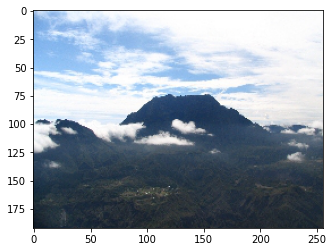

In [8]:
plt.imshow(queries[15])

## relevant

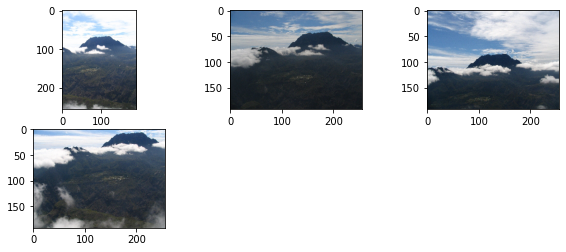

In [9]:
displayImages(images[y_true[15]])

## Calculate Distance

In [10]:
distance_matrix = np.zeros((len(queries_vec),len(images_vec)))

In [11]:
for i,query in enumerate(queries_vec):
    for j,img in enumerate(images_vec):
        distance_matrix[i,j] = np.linalg.norm(query-img)

## Example 1 

In [12]:
most_similar = distance_matrix[1].argmin()

In [13]:
distance_matrix[1][most_similar]

2059.8123700958786

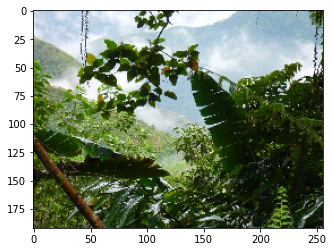

In [14]:
plt.imshow(queries[1])

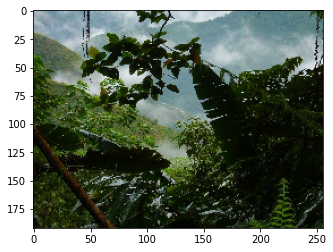

In [15]:
plt.imshow(images[most_similar])

## top 10

In [16]:
k = 10

In [17]:
def getKrelevants(queryId,distanceMatrix,k=10):
    return np.argsort(distanceMatrix[queryId])[:k]

In [18]:
query_img = 64

In [19]:
retrieves = getKrelevants(query_img,distance_matrix,k)

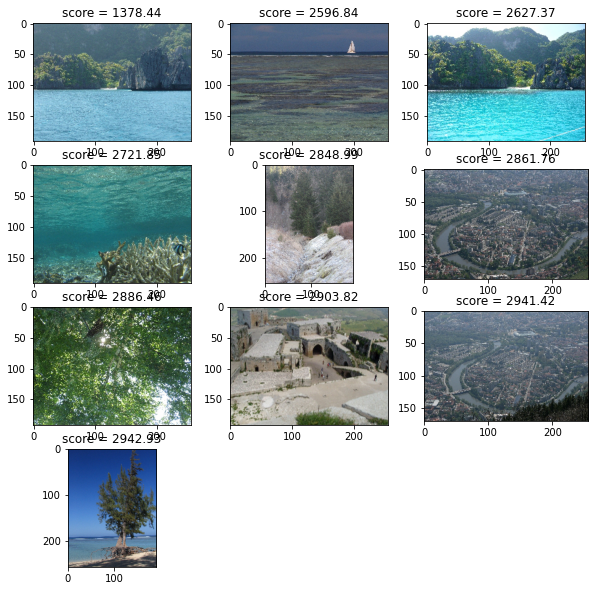

In [20]:
displayImages(images[retrieves],distance_matrix[query_img][retrieves])

### Plot Precision and Recall

In [21]:
def precision_recall(retrieves,truth):
    recall = []
    precision = []
    p=[]
    nelt = 0
    nth = len(truth)
    for i,r in enumerate(retrieves):
        n = i+1
        if r in truth:
            nelt+=1
            p.append(nelt/n)
        precision.append(nelt/n)
        recall.append(nelt/nth)
    av = np.sum(p)/nth 
    return recall,precision,av

In [22]:
truth = y_true[query_img]

In [23]:
truth

[111, 112, 113]

In [24]:
recall,precision,av = precision_recall(retrieves,truth)

In [25]:
recall = np.array(recall)
precision = np.array(precision)

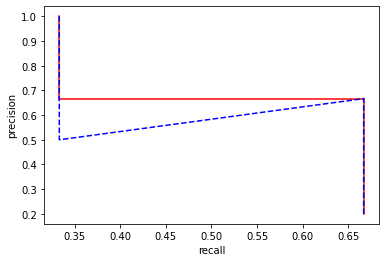

In [26]:
import numpy as np
import matplotlib.pyplot as plt


precision2=precision.copy()
i=recall.shape[0]-2
while i>=0:
    if precision[i+1]>precision[i]:
        precision[i]=precision[i+1]
    i=i-1

fig, ax = plt.subplots()
for i in range(recall.shape[0]-1):
    ax.plot((recall[i],recall[i]),(precision[i],precision[i+1]),'k-',label='',color='red') #vertical
    ax.plot((recall[i],recall[i+1]),(precision[i+1],precision[i+1]),'k-',label='',color='red') #horizontal

ax.plot(recall,precision2,'k--',color='blue')
ax.set_xlabel("recall")
ax.set_ylabel("precision")
fig.show()

## 3 - Compute global evaluation on 500 queries

#### map Average precision

In [27]:
def m_map(responses,truths):
    avp = []
    for nimg in range(len(responses)):
        truth = truths[nimg]
        retrieves = responses[nimg]
        n_th = len(truth)
        n_ret = 0
        _,_,av = precision_recall(retrieves,truth)
        avp.append(av)
    return np.mean(avp),avp

In [28]:
def generateResult(file_name,queries,y_true,queries_names,base_images,distance_matrix,k=10):
    results = []
    res = []
    truths = []
    for q in range(len(queries)):
        res.append(getKrelevants(q,distance_matrix,k))
        truths.append(y_true[q])
        results.append(queries_names[q])
        for j,r in enumerate(res[q]):
            if(r in truths[q]):
                results [q] += " " + str(j) + " " + base_images[q][truths[q].index(r)]
    print(len(results))
    str_results = '\n'.join(results)
    f = open(file_name, "w")
    f.write(str_results)
    f.close()

In [29]:
from holidays_map import *

In [30]:
def mAPEvaluation(file_result):
    #########################################################################
    # main program
    infilename=file_result

    (allnames,gt)=get_groundtruth()
    # sum of average precisions
    sum_ap=0.
    # nb of images so far
    n=0

    # loop over result lines
    for query_name,results in parse_results(infilename):

        if query_name not in gt:
            print ("unknown query " + query_name)
            sys.exit(1)

        # sort results by increasing rank
        results = sorted([(k, v) for (k, v) in results])

        # ground truth
        gt_results=gt.pop(query_name)

        # ranks of true positives (not including the query)
        tp_ranks=[]

        # apply this shift to ignore null results
        rank_shift=0

        for rank,returned_name in results:
            if returned_name not in allnames:
                print ("image name %s not in Holidays" %returned_name)
                sys.exit(1)

            if returned_name==query_name:
                rank_shift=-1
            elif returned_name in gt_results:
                tp_ranks.append(rank+rank_shift)      

        sum_ap+=score_ap_from_ranks_1(tp_ranks,len(gt_results))
        n+=1


    if gt:
      # some queries left
      print ("no result for queries: ") 
      print (gt.keys())

    print ("mAP for %s: %.5f" %(infilename,sum_ap/n))

### Pixels Diff top 10

In [33]:
file ="res/results_diff_color_10k.txt" 

In [34]:
generateResult(file,queries,y_true,queries_names,base_images,distance_matrix)

500


In [35]:
mAPEvaluation(file)

mAP for res/results_diff_color_10k.txt: 0.02589


### Pixels Diff top 5

In [36]:
file ="res/results_diff_color_5k.txt" 

In [37]:
generateResult(file,queries,y_true,queries_names,base_images,distance_matrix,k=5)

500


In [38]:
mAPEvaluation(file)

mAP for res/results_diff_color_5k.txt: 0.02504


In [39]:
file ="res/results_diff_color_1k.txt" 

In [48]:
generateResult(file,queries,y_true,queries_names,base_images,distance_matrix,k=1)

500


In [49]:
mAPEvaluation(file)

mAP for res/results_hists_color_10k.txt: 0.02015


## 4 Improving the Image description and similarity metrics

In [50]:
def calculateDistanceMatrix(queries_features,images_features):
    distance_matrix = np.zeros((len(queries_features),len(images_features)))
    for i,query in tqdm(enumerate(queries_features)):
        for j,image in enumerate(images_features):
            distance_matrix[i,j] = cdist(np.array([query]),np.array([image]),'cosine')
    return distance_matrix

### Descriptors


### Histogram color

In [51]:
def extractHistColor(imgs,bins = 30):
    histColor = []
    for i in tqdm(imgs):
        description = np.array([])
        for c in range(3):
            hist_val, _ = np.histogram(i[:,:,c],bins=bins)
            description = np.concatenate((description, hist_val),axis=None)
        description /= description.sum()
        histColor.append(description)
    return histColor

In [53]:
%%time
images_hists = extractHistColor(images)
queries_hists = extractHistColor(queries)
hist_similarity_matrix = calculateDistanceMatrix(queries_hists,images_hists)
file ="res/results_hists_color_10k.txt" 
generateResult(file,queries,y_true,queries_names,base_images,hist_similarity_matrix,k=10)
mAPEvaluation(file)

100%|██████████| 500/500 [00:01<00:00, 356.76it/s]
500it [00:11, 44.81it/s]

500
mAP for res/results_hists_color_10k.txt: 0.30411
CPU times: user 15.3 s, sys: 67.2 ms, total: 15.4 s
Wall time: 15.3 s


## Results

|     | Elapsed Time | mAP |
|:---:|:------------:|:---:|
| color hist |   14.2 s           |0.304     |


### Harlick

In [57]:
from skimage import data, exposure
from skimage.feature import hog
import mahotas as mt


In [58]:
def extractHaralick(imgs):
    haralick_features = []
    for i in imgs:
        textures = mt.features.haralick(i)
        ht_mean = textures.mean(axis=0)
        haralick_features.append(ht_mean)
    return haralick_features

In [60]:
haralick_feature_imgs = extractHaralick(images)

In [61]:
haralick_feature_queries = extractHaralick(queries)

In [62]:
haralick_similarity_matrix = calculateDistanceMatrix(haralick_feature_queries,haralick_feature_imgs)

500it [00:10, 47.28it/s]


## Evaluation

In [63]:
file ="res/results_haralick_10k.txt" 

In [65]:
generateResult(file,queries,y_true,queries_names,base_images,haralick_similarity_matrix,k=10)

500


In [66]:
mAPEvaluation(file)

mAP for res/results_haralick_10k.txt: 0.05152


### LBP

In [220]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

In [221]:
def lbp_features(imgs, radius=1, neighbors=8):
    set_points = radius*neighbors
    lbps = []
    for img in imgs:
        img = rgb2gray(img)
        lbp = local_binary_pattern(img, set_points, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, set_points), range=(0, set_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbps.append(hist)
    return lbps

In [228]:
def lbp_experience(images,queries,params):
    lbp_features_images = lbp_features(images,**params)
    lbp_features_queries = lbp_features(queries,**params)
    lbp_similarity_matrix = calculateDistanceMatrix(lbp_features_queries,lbp_features_images)    
    file = "res/results_lbp_"+json.dumps(params)+"_10k.txt" 
    generateResult(file,queries,y_true,queries_names,base_images,lbp_similarity_matrix,k=10)
    mAPEvaluation(file)

In [229]:
p_1_8 = {
    "radius" :1,
    "neighbors":8
}
p_2_16 = {
    "radius":2,
    "neighbors":16*2
}
p_3_16 = {
    "radius":3,
    "neighbors":16*3
}

In [230]:
%%time
lbp_experience(images_org,queries_org,p_1_8)

500it [00:10, 48.60it/s]

500
mAP for res/results_lbp_{"radius": 1, "neighbors": 8}_10k.txt: 0.11661
CPU times: user 23.1 s, sys: 37.3 ms, total: 23.2 s
Wall time: 23.1 s


In [225]:
%%time
lbp_experience(images_org,queries_org,p_2_16)

500it [00:10, 49.47it/s]


500
mAP for res/results_lbp_10k.txt: 0.15794
CPU times: user 1min 19s, sys: 40.1 ms, total: 1min 19s
Wall time: 1min 19s


In [226]:
%%time 
lbp_experience(images_org,queries_org,p_3_16)

500it [00:11, 43.71it/s]

500
mAP for res/results_lbp_10k.txt: 0.18086
CPU times: user 2min 41s, sys: 90.4 ms, total: 2min 41s
Wall time: 2min 41s


## Results

|     | Radius | Neigbors | Elapsed Time | mAP |
|:---:|:------:|:--------:|:------------:|:---:|
| LBP |    1   |     8    | 22.7 s             | 0.11661    |
| LBP |    2   |   16*2   | 1min 19s             |0.15794     |
| LBP |    3   |   32*3   |     2min 36s         | 0.18086    |

### Hog Descriptor

In [81]:
from skimage import data, exposure
from skimage.feature import hog

In [82]:
fixed_size_img = []
fixed_size_qrs = []
for i in images:
    im = Image.fromarray(i).resize(max_size)
    img = np.array(im)
    fixed_size_img.append(img)
for i in queries:
    im = Image.fromarray(i).resize(max_size)
    img = np.array(im)
    fixed_size_qrs.append(img)

In [83]:
def hog_descriptors(imgs,orientations=16,pixels_per_cell=(16,16),cells_per_block=(2,2)):
    print(pixels_per_cell)
    hog_vectors = []
    for i in tqdm(imgs):
        fd = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block, multichannel=True)
        hog_vectors.append(fd)
    return hog_vectors

In [84]:
def hog_experiment(imgs,qrs,params):
    hog_feature_imgs = hog_descriptors(imgs,**params)
    hog_feature_queries = hog_descriptors(qrs,**params)
    hog_similarity_matrix = calculateDistanceMatrix(hog_feature_queries,hog_feature_imgs)
    file = "res/results_hog_"+json.dumps(params)+"_10k.txt" 
    generateResult(file,queries,y_true,queries_names,base_images,hog_similarity_matrix,k=10)
    mAPEvaluation(file)

In [85]:
hog_8_16x16_1x1 = {
    "orientations" : 8,
    "pixels_per_cell":(16,16),
    "cells_per_block":(1,1)
}

In [86]:
%%time
hog_experiment(fixed_size_img,fixed_size_qrs,hog_8_16x16_1x1)

  1%|          | 5/991 [00:00<00:20, 49.16it/s]

(16, 16)


  1%|          | 6/500 [00:00<00:08, 56.88it/s]

(16, 16)


100%|██████████| 500/500 [00:08<00:00, 55.97it/s]
500it [00:14, 34.90it/s]

500
mAP for res/results_hog_{"orientations": 8, "pixels_per_cell": [16, 16], "cells_per_block": [1, 1]}_10k.txt: 0.00247
CPU times: user 41 s, sys: 0 ns, total: 41 s
Wall time: 40.9 s


## Bag Of Visual Words 

In [78]:
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.cluster import KMeans
from skimage import feature

class BVW:
    def __init__(self,imgs_base,dict_size=200,patch_size=(20,20),n_patches=300,base_descriptor='color_histogram',descparams={}):
        self.imgs_base = imgs_base
        self.dict_size = dict_size
        self.n_patches = n_patches
        self.patch_size = patch_size
        self.summary  = None
        self.descriptor=None
        if(base_descriptor == 'color_histogram'):
            self.descriptor = self.color_histogram_descriptor
        elif(base_descriptor == 'lbp'):
            self.descriptor = self.lbp_features
        elif(base_descriptor == 'hog'):
            self.descriptor = self.hog_descriptors
        self.descparams = descparams
        self.construct_dict()
    
    def get_patches(self,img,random_state=42):
        patch = extract_patches_2d(img, 
                               patch_size=self.patch_size,
                               max_patches=self.n_patches, 
                               random_state=random_state)
        return patch
        
    def color_histogram_descriptor(self,imgs,bins = 30):
        histColor = []
        for i in imgs:
            description = np.array([])
            for c in range(3):
                hist_val, _ = np.histogram(i[:,:,c],bins=bins)
                description = np.concatenate((description, hist_val),axis=None)
            description /= description.sum()
            histColor.append(description)
        return histColor
        
    def lbp_features(imgs, radius=1, neighbors=8):
        set_points = radius*neighbors
        lbps = []
        for img in imgs:
            img = rgb2gray(img)
            lbp = local_binary_pattern(img, set_points, radius, method="uniform")
            (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, set_points), range=(0, set_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-6)
            lbps.append(hist)
        return lbps
  
    def hog_describe(self,img, orientations=9,pix_per_cell=4, cell_per_block=2):
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.extend(hog(img, orientations=orientations,
                          pixels_per_cell=(pix_per_cell, pix_per_cell),
                          cells_per_block=(cell_per_block, cell_per_block),
                          block_norm='L1', transform_sqrt=True, feature_vector=True))
        return np.array(hog_features)

    def hog_descriptors(self,imgs):
        hog_vectors = []
        for i in imgs:
            fd = self.hog_describe(i,**self.descparams)
            hog_vectors.append(fd)
        return hog_vectors
    
    def construct_dict(self):
        patch_description = []
        for i in tqdm(self.imgs_base):
            patch_description +=self.descriptor(self.get_patches(i),**self.descparams)
        print(np.array(patch_description).shape)
        self.summary = KMeans(n_clusters=self.dict_size, 
                      verbose=False, 
                      init='random',
                      random_state=42)
        self.summary.fit(patch_description)
    
    def describe(self,imgs):
        description = []
        for i in imgs:          
            patch_description = self.descriptor(self.get_patches(i),**self.descparams)
            y = self.summary.predict(patch_description)
            histOfBVW,_ = np.histogram(y, bins=range(self.dict_size+1), density=True)
            description.append(histOfBVW)
        return description
        

In [79]:
def boVWExp(images,queries,params):
    bagOfVW = BVW(images,**params)
    bovw_images = bagOfVW.describe(images)
    bovw_queries = bagOfVW.describe(queries)
    bovw_similarity_matrix = calculateDistanceMatrix(bovw_queries,bovw_images)
    file ="res/results_bovw"+json.dumps(params)+"_10k.txt" 
    generateResult(file,queries,y_true,queries_names,base_images,bovw_similarity_matrix,k=10)
    mAPEvaluation(file)

#### Base descriptor : color histogram

In [80]:
bvw_histColor_d200_n100 = {
    "descparams":{
    },
    "n_patches":100,
    "dict_size":200,
    "base_descriptor":"color_histogram",
}
bvw_histColor_d200_n300 = {
    "descparams":{
    },
    "n_patches":300,
    "dict_size":200,
    "base_descriptor":"color_histogram",
}

bvw_histColor_d50_n200 = {
    "descparams":{
    },
    "n_patches":200,
    "dict_size":50,
    "base_descriptor":"color_histogram",
}

bvw_histColor_d20_n250 = {
    "descparams":{
    },
    "n_patches":250,
    "dict_size":20,
    "base_descriptor":"color_histogram",
}

In [56]:
%%time
boVWExp(images,queries,bvw_histColor_d200_n100)

100%|██████████| 991/991 [00:43<00:00, 22.66it/s]


(99100, 90)


500it [00:09, 53.35it/s]

500
mAP for res/results_bovw{"descparams": {}, "n_patches": 100, "dict_size": 200, "base_descriptor": "color_histogram"}_10k.txt: 0.29674
CPU times: user 13min 35s, sys: 6min 23s, total: 19min 58s
Wall time: 12min 42s


In [57]:
%%time
boVWExp(images,queries,bvw_histColor_d200_n300)

100%|██████████| 991/991 [02:10<00:00,  7.60it/s]


(297300, 90)


500it [00:09, 53.00it/s]

500
mAP for res/results_bovw{"descparams": {}, "n_patches": 300, "dict_size": 200, "base_descriptor": "color_histogram"}_10k.txt: 0.40408
CPU times: user 38min 59s, sys: 8min 27s, total: 47min 26s
Wall time: 37min 49s


In [58]:
%%time
boVWExp(images,queries,bvw_histColor_d50_n200)

100%|██████████| 991/991 [01:26<00:00, 11.42it/s]


(198200, 90)


500it [00:09, 54.06it/s]

500
mAP for res/results_bovw{"descparams": {}, "n_patches": 200, "dict_size": 50, "base_descriptor": "color_histogram"}_10k.txt: 0.27039
CPU times: user 11min 1s, sys: 2min 48s, total: 13min 50s
Wall time: 10min 39s


In [59]:
boVWExp(images,queries,bvw_histColor_d20_n250)

100%|██████████| 991/991 [01:50<00:00,  8.99it/s]


(247750, 90)


500it [00:09, 55.23it/s]

500
mAP for res/results_bovw{"descparams": {}, "n_patches": 250, "dict_size": 20, "base_descriptor": "color_histogram"}_10k.txt: 0.17482


### Base descriptor : LBP

In [74]:
bvw_lbp_d200_n200 = {
    "descparams":{
        "radius":2, 
        "neighbors":16
    },
    "n_patches":200,
    "dict_size":200,
    "base_descriptor":"lbp",
}
bvw_lbp_d200_n400 = {
    "descparams":{
        "radius":2, 
        "neighbors":16
    },
    "n_patches":400,
    "dict_size":200,
    "base_descriptor":"lbp",
}

bvw_lbp_d50_n200 = {
    "descparams":{
        "radius":2, 
        "neighbors":16
    },
    "n_patches":200,
    "dict_size":50,
    "base_descriptor":"lbp",
}


bvw_lbp_d20_n250 = {
    "descparams":{
        "radius":2, 
        "neighbors":16
    },
    "n_patches":250,
    "dict_size":20,
    "base_descriptor":"lbp",
}


In [75]:
%%time
boVWExp(images,queries,bvw_lbp_d200_n100)

100%|██████████| 991/991 [01:33<00:00, 10.54it/s]
500it [00:11, 43.86it/s]


500
mAP for res/results_bovw{"descparams": {"radius": 2, "neighbors": 16}, "n_patches": 200, "dict_size": 200, "base_descriptor": "lbp"}_10k.txt: 0.22884
CPU times: user 28min 3s, sys: 7min 46s, total: 35min 50s
Wall time: 27min 13s


In [76]:
%%time
boVWExp(images,queries,bvw_lbp_d200_n400)

100%|██████████| 991/991 [03:08<00:00,  5.25it/s]
500it [00:11, 44.06it/s]

500
mAP for res/results_bovw{"descparams": {"radius": 2, "neighbors": 16}, "n_patches": 400, "dict_size": 200, "base_descriptor": "lbp"}_10k.txt: 0.29581
CPU times: user 54min 23s, sys: 7min 47s, total: 1h 2min 11s
Wall time: 53min 31s


In [80]:
%%time
boVWExp(images,queries,bvw_lbp_d50_n200)

100%|██████████| 991/991 [01:35<00:00, 10.40it/s]
500it [00:10, 45.46it/s]

500
mAP for res/results_bovw{"descparams": {"radius": 2, "neighbors": 16}, "n_patches": 200, "dict_size": 50, "base_descriptor": "lbp"}_10k.txt: 0.19782
CPU times: user 11min 17s, sys: 6min 40s, total: 17min 57s
Wall time: 10min 30s


In [78]:
boVWExp(images,queries,bvw_lbp_d20_n250)

100%|██████████| 991/991 [02:00<00:00,  8.26it/s]
500it [00:10, 45.82it/s]

500
mAP for res/results_bovw{"descparams": {"radius": 2, "neighbors": 16}, "n_patches": 250, "dict_size": 20, "base_descriptor": "lbp"}_10k.txt: 0.16621


### Base descriptor : Hog

In [88]:
bvw_hog_d200_n200 = {
    "descparams":{
    },
    "n_patches":200,
    "dict_size":200,
    "base_descriptor":"hog",
}

In [68]:
%%time
boVWExp(images,queries,bvw_hog_d200_n200)

100%|██████████| 991/991 [07:32<00:00,  2.19it/s]


(198200, 1728)


500it [00:11, 42.39it/s]


500
mAP for res/results_bovw{"descparams": {}, "n_patches": 200, "dict_size": 200, "base_descriptor": "hog"}_10k.txt: 0.14049
CPU times: user 2h 5min 43s, sys: 7min 17s, total: 2h 13min
Wall time: 2h 6min 41s


### Results BOVW

| descriptor      | N_patches | Dictionary Size | Time        | mAP     |
|-----------------|-----------|-----------------|-------------|---------|
| Color Histogram | 100       | 200             | 12min 42s   | 0.296   |
| Color Histogram | 300       | 200             | 37min 49s   | 0.404   |
| Color Histogram | 200       | 50              | 10min 39s   | 0.27039 |
| Color Histogram | 250       | 20              |             | 0.17482 |
| LBP             | 200       | 200             | 27min 13s   | 0.22884 |
| LBP             | 400       | 200             | 53min 31s   | 0.29581 |
| LBP             | 200       | 50              | 10min 30s   | 0.19782 |
| LBP             | 250       | 20              |             | 0.16621 |
| HOG             | 200       | 200             | 2h 6min 41s | 0.14049 |

### CNN Feature extraction

In [241]:
from keras import applications
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input


In [242]:
def resNetFeatureExtraction(images):
    imgs = []
    if(type(images[0]) == list):
        for x in images:
            for j in x:
                imgs.append(j)
        images = imgs
        
    featuresVecs = []
    folder ="smallholidays"
    model = applications.resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')
    # load image setting the image size to 224 x 224
    for i in images:
        img = image.load_img(folder + "/" + i, target_size=(224, 224))
        # convert image to numpy array
        x = image.img_to_array(img)
        # the image is now in an array of shape (3, 224, 224)
        # need to expand it to (1, 3, 224, 224) as it's expecting a list
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # extract the features
        features = model.predict(x)[0]
        # convert from Numpy to a list of values
        features_arr = np.char.mod('%f', features)
        featuresVecs.append(features_arr)
    return featuresVecs

In [243]:
queries_cnn_vec = resNetFeatureExtraction(queries_names)

In [244]:
images_cnn_vec = resNetFeatureExtraction(base_images)

In [245]:
cnn_similarity_matrix = calculateDistanceMatrix(queries_cnn_vec,images_cnn_vec)

500it [20:36,  2.47s/it]


## Evaluation

In [246]:
file ="res/results_cnn_10k.txt" 

In [247]:
generateResult(file,queries,y_true,queries_names,base_images,cnn_similarity_matrix,k=10)

500


In [248]:
mAPEvaluation(file)

mAP for res/results_cnn_10k.txt: 0.80020
